In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

### Génération d'un TVAR(d)

On génère un TVAR à partir de corrélations partielles choisies au hasard dans l'algorithme de Levinson.

In [2]:
def generation_TVAR(d, T, epsilon):
    
    """generation des coefficients du TVAR par les corrélations partielles de l'algorithme de Levinson"""
    
    u = np.arange(T, dtype='double') / T
    kappa = np.zeros((d,T))
    for k in np.arange(d):
        kappa[k,:] =  (-1) ** k * np.power(1-2 * u, k)
    for t in np.arange(T):
        kappa[:,t] = kappa[:,t]/max(abs(kappa[:,t])) # on s'assure de ne jamais toucher 1 ou -1 
    
    theta = np.matrix(np.zeros((d,T)))
    theta_inter = np.matrix(np.zeros((d,d)))
    X = epsilon
    
    for t in np.arange(T):
        for k in np.arange(d):
            theta_inter[k,k] = kappa[k,t]
        for p in np.arange(1, d):
            for k in np.arange(0, p-1):
                theta_inter[k,p] = theta_inter[k, p-1] - kappa[p,t] * theta_inter[p-k,p-1]
        theta[:,t] = theta_inter[:,d-1]

        X[T + t] = np.dot(X[T+t-d:T+t][::-1], theta[:,t]) + X[T+t]
        
    return X, theta

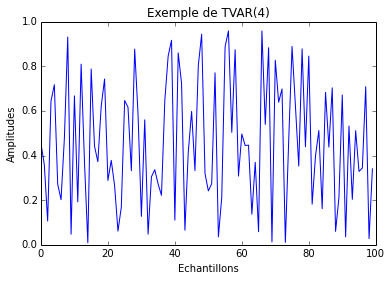

In [14]:
d = 4
T = int(1e2)
epsilon = np.random.rand(2*T)
X, theta = generation_TVAR(d, T, epsilon)

plt.plot(X[:T])
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple de TVAR({})".format(d))

### Analyse spectrale

In [4]:
from scipy.fftpack import fft

def dsp(theta, T, N = 512):
    dsp_array = np.matrix(np.zeros((N, T)))
    
    for t in np.arange(T):
        dsp_array[:,t] = np.matrix(1./abs(fft(theta[:,t].T, N)) ** 2).T
        
    lambd = np.arange(N, dtype = 'double')/N
        
    return lambd, dsp_array

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


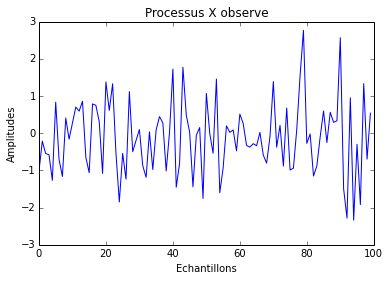

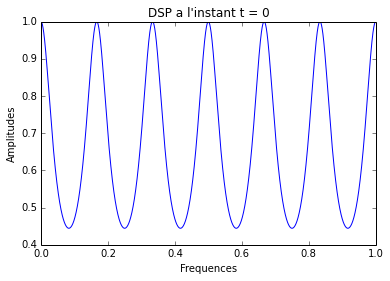

In [17]:
d = 8
T = int(1e2)
epsilon = np.random.randn(2*T)

X, theta = generation_TVAR(d, T, epsilon)

plt.figure()
plt.plot(X[:T])
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Processus X observe")

f, dsp_array = dsp(theta, T, 2**12)

plt.figure()
plt.plot(f, dsp_array[:,0]/max(abs(dsp_array[:,0])))
plt.xlabel("Frequences")
plt.ylabel("Amplitudes")
plt.title("DSP a l'instant t = 0")

### Construction d'un estimateur en ligne

In [19]:
from scipy.linalg import norm

def generation_est(X, d, T, mu):

    theta_est = np.matrix(np.zeros((d,T)))
    X_est = np.zeros(T)
    
    for k in (np.arange(T)): # on fait T itérations
        XX = X[T+k-d:T+k][::-1]
        
        if k==0:
            theta_est[:,k] = np.matrix(mu * X[T+k] * XX / (1 + mu * norm(XX) ** 2)).T 
        else:
            theta_est[:,k] = np.matrix(theta_est[:,k-1].T + mu * (X[T+k] - np.dot(XX, theta_est[:,k-1])) * XX / (1 + mu * norm(XX) ** 2)).T  

        X_est[k] = np.dot(XX, theta_est[:,k])
        
    return X_est, theta_est

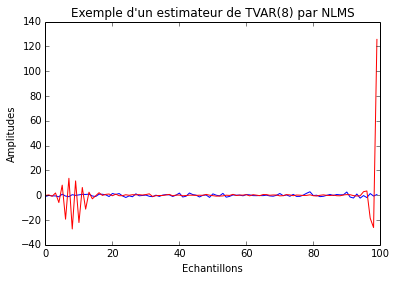

In [22]:
X_est, theta_est = generation_est(X, d, T, 0.005)

plt.plot(X[:T])
plt.plot(X_est[:T], 'r')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple d'un estimateur de TVAR({}) par NLMS".format(d))

### Estimation par aggregation

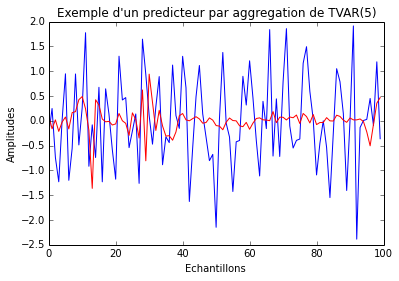

In [77]:
# INITIALISATION

T = int(1e2)
d = 5
log_mu = np.arange(-2, 0, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)
estimations = np.matrix(np.zeros((N, T)))

for k in np.arange(N):
    estimations[k,:] = generation_est(X, d, T, mu[k])[0]

eta = 1
strategy = 1
alpha = 1./N * np.ones(N)
pred = np.zeros(T)

# ALGO D'ACCUMULATION

for t in np.arange(T):
    #print (np.dot(alpha, estimations[:,t]).shape)
    pred[t] = np.dot(alpha, estimations[:,t])
    
    if t > 0:
        v = np.zeros(N)
        for i in np.arange(N):
            if strategy == 1:
                v[i] = alpha[i] * np.exp(-2*eta*(pred[t-1]-X[t-1])*estimations[i,t-1])
            else:
                v[i] = alpha[i] * np.exp(-eta*(estimations[i,t-1]-X[t-1])**2)
        alpha = v / np.sum(v)
      
plt.plot(np.arange(T), X[:T], 'b')
plt.plot(np.arange(T), pred, 'r')
plt.xlabel("Echantillons")
plt.ylabel("Amplitudes")
plt.title("Exemple d'un predicteur par aggregation de TVAR({})".format(d))


In [99]:
#FACTORISATION EN FONCTION

def aggregation(X, estimations, T, eta, stragegy = 1):
    
    """Retourne un predicteur par aggregation"""
    
    N = len(estimations[:,0])
    pred = np.zeros(T)
    alpha = 1./N * np.ones(N)
    
    for t in np.arange(T):
    
        if t > 0:
            v = np.zeros(N)
            for i in np.arange(N):
                if strategy == 1:
                    v[i] = alpha[i] * np.exp(-2*eta*(pred[t-1]-X[t-1])*estimations[i,t-1])
                else:
                    v[i] = alpha[i] * np.exp(-eta*(estimations[i,t-1]-X[t-1])**2)
            alpha = v / np.sum(v)
            
        pred[t] = np.dot(alpha, estimations[:,t])
            
    return pred

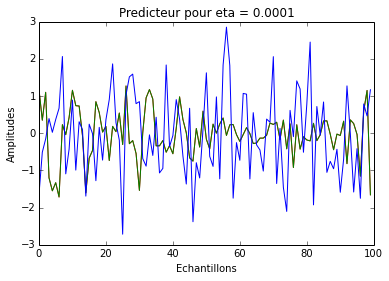

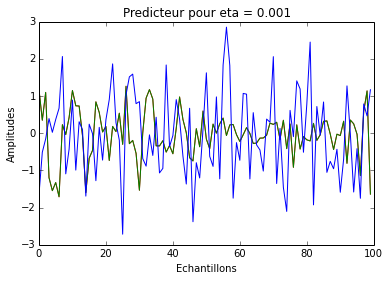

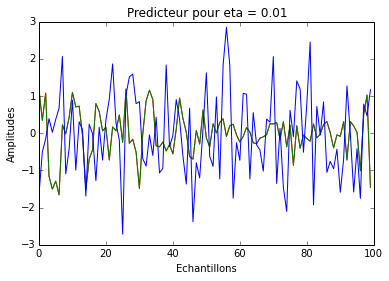

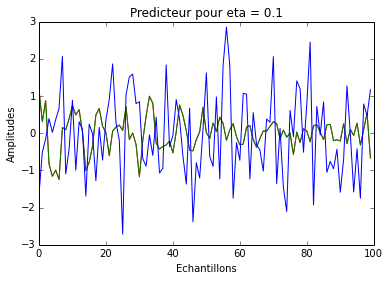

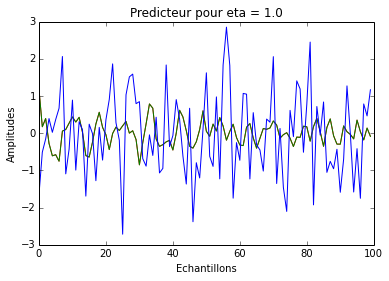

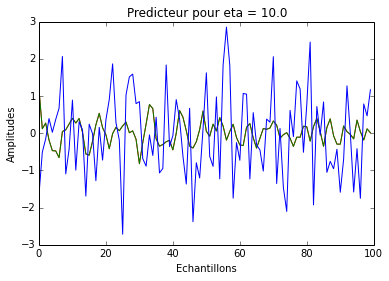

In [106]:
#initalisation
log_eta = np.arange(-4,2,1.0)
eta = np.power(10, log_eta)
T = int(1e2)
d = 4
epsilon = np.random.randn(2*T)
X = generation_TVAR(d, T, epsilon)[0]

# Estimation
log_mu = np.arange(-2, 0, 0.1)
N = len(log_mu)
mu = np.power(10, log_mu)
estimations = np.matrix(np.zeros((N, T)))

for k in np.arange(N):
    estimations[k,:] = generation_est(X, d, T, mu[k])[0]

# Aggregation et affichage
for n in np.arange(len(eta)):
    current_eta = eta[n]
    pred1 = aggregation(X, estimations, T, current_eta, 1)
    pred2 = aggregation(X, estimations, T, current_eta, 2)
    
    plt.figure()
    plt.plot(pred1, 'r')
    plt.plot(pred2, 'g')
    plt.plot(X[:T], 'b')
    plt.xlabel("Echantillons")
    plt.ylabel("Amplitudes")
    plt.title("Predicteur pour eta = {}".format(current_eta))

### Exemple 1 : un TVAR(d) quelconque

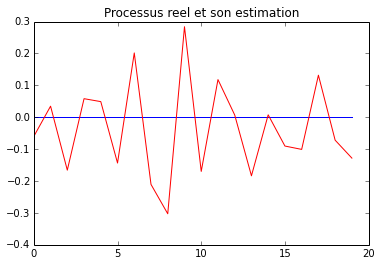

In [51]:
d = 20
T = int(5e2)
mu = 5e-2 #d=2 -> mu = 1, d=10 -> mu = 0.5
epsilon = np.random.randn(2*T)

theta = generation_TVAR(d, T, epsilon)[1]
theta_est = generation_est(X, d, T, mu)[1]

plt.figure()
plt.plot(theta[:,T/2], 'b', label = 'X')
plt.plot(theta_est[:,T/2], 'r', label = 'X_est')
plt.title("Processus reel et son estimation")

#### Estimation paramétrique

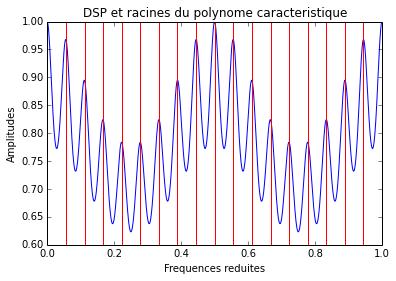

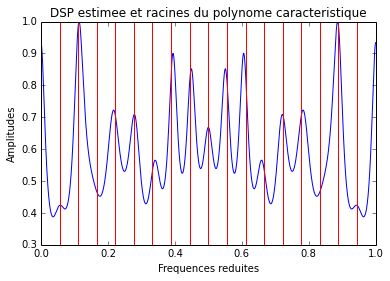

In [29]:
N = 2**12

coeffs = np.ones((d+1,T))
coeffs[1:,:] = -theta #polynome caractértistique

coeffs_est = np.ones((d+1,T))
coeffs_est[1:,:] = -theta_est #polynome caractértistique

f, dsp_X = dsp(coeffs, T, N)
f, dsp_X_est = dsp(coeffs_est, T, N)


roots = np.roots(coeffs[:,0][::-1])
#print("Les racines approche du polynome caracteristique sont {}".format(roots))
angles = (np.angle(roots) + np.pi) / (2*np.pi)
#print("Les phases associees sont {}".format(angles))

        

lambd = np.arange(N, dtype = 'double') / N

plt.figure()
plt.plot(lambd, dsp_X[:,0]/np.max(abs(dsp_X[:,0])), 'b', label ='vraie DSP')
for k in np.arange(d):
    plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP et racines du polynome caracteristique")

plt.figure()
plt.plot(lambd, dsp_X_est[:,0]/np.max(abs(dsp_X_est[:,0])), 'b', label = 'DSP estimee')
for k in np.arange(d):
    plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.xlabel("Frequences reduites")
plt.ylabel("Amplitudes")
plt.title("DSP estimee et racines du polynome caracteristique")

#### Estimation non-paramétrique

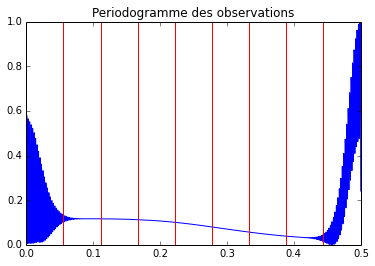

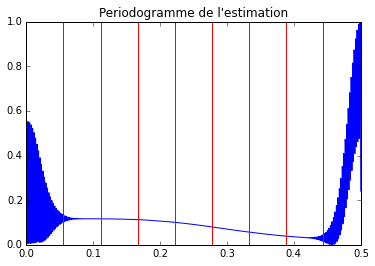

In [26]:
from scipy.signal import periodogram

N = 2**12

f, Pxx = periodogram(X, nfft = N)
f, Pxx_est = periodogram(X_est, nfft = N)

plt.figure()
plt.plot(f, Pxx/np.max(abs(Pxx)), 'b', label ='vraie DSP')
for k in np.arange(d):
    if angles[k] >= 0 and angles[k] < 0.5:
        plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme des observations")
        
plt.figure()
plt.plot(f, Pxx_est/np.max(abs(Pxx_est)), 'b', label = 'DSP estimee')
for k in np.arange(d):
    if angles[k] >= 0 and angles[k] < 0.5:
        plt.axvline(x=angles[k], ymin=0, ymax=1, linewidth=1, color = 'r')
plt.title("Periodogramme de l'estimation")

### Exemple 2 : "a-e-i-o-u"